In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import re
import ssl

In [2]:
# Source: https://github.com/gunthercox/ChatterBot/issues/930#issuecomment-322111087 
# This is to fix the SSL error when downloading nltk data, which is a known issue on Mac OS
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaeld./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/michaeld./nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/michaeld./nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Function for text preprocessing
def preprocess_text(text):
    print(text)

    # Remove digits
    text = text.replace('\d+', '')
    
    # Clean urls
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub('', text)
    
    # Lowercasing
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Removing stopwords and non-alphanumeric characters
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.isalnum() and token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

In [4]:
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', (word))
        new_words.append(new_word)
    return new_words

In [5]:
train_df = pd.read_csv("data_train_preprocessed.csv")
test_df = pd.read_csv("data_test_preprocessed.csv")

train_df['processed_text_alt'] = train_df['processed_text_alt'].fillna('')
test_df['processed_text_alt'] = test_df['processed_text_alt'].fillna('')

print(train_df['processed_text_alt'])

0       bernie elizabeth issue matter issue make danke...
1       extending brexit deadline october 31st order e...
2       kwai gkwa 0964 nnevvy applause thai hong kong ...
3       order foce mask protect ogainst fhe corond vir...
4       best candidate ja 2020 joe biden kamala harris...
                              ...                        
3008    jim halpert jimhalpert everybody 2020 finally ...
3009    litquidity elihcapital yofollewine covid 19 sy...
3010    meta sending dog supply since contract coc 100...
3011    people born boveteojoe foleing coming week soy...
3012               washing hand 20 second 57 time one day
Name: processed_text_alt, Length: 3013, dtype: object


In [6]:
train_tokens = [token for tokens_list in train_df['processed_text_alt'] for token in tokens_list]
preprocessed_train_tokens = [token for tokens_list in train_df['processed_text_alt'] for token in tokens_list]

vocabulary_size = len(set(train_tokens))
vocabulary_size_preprocessed = len(set(preprocessed_train_tokens))

print(f'Vocabulary Size Preprocessed: {vocabulary_size_preprocessed}')
print(f'Vocabulary Size: {vocabulary_size}')

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

Vocabulary Size Preprocessed: 132
Vocabulary Size: 132


In [7]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=100)  # Adjust max_features based on dataset size
X_train = vectorizer.fit_transform(train_df['processed_text_alt']).toarray()
X_val = vectorizer.transform(val_df['processed_text_alt']).toarray()
X_test = vectorizer.transform(test_df['processed_text_alt']).toarray()
y_train = (train_df['binary_labels']).astype(int).values
y_val = (val_df['binary_labels']).astype(int).values
y_test = (test_df['binary_labels']).astype(int).values

In [8]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [9]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

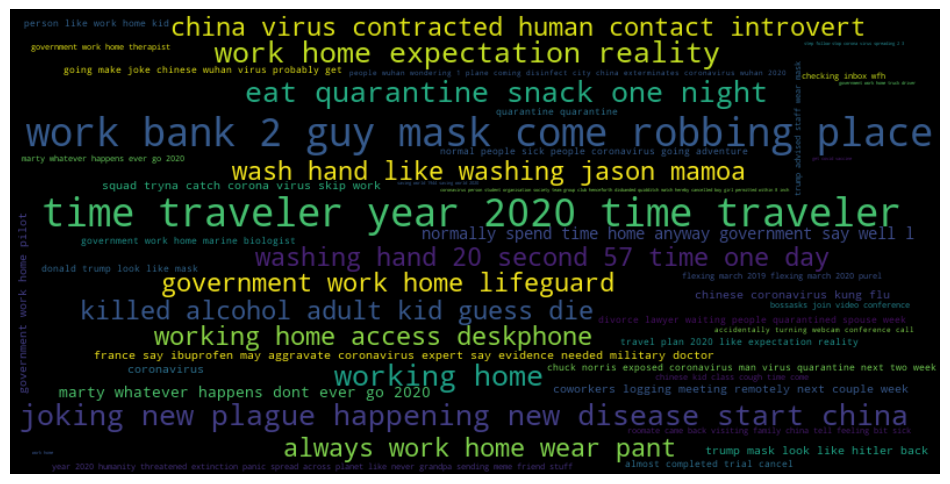

In [10]:
from wordcloud import WordCloud
#Frequency of words
fdist = FreqDist(train_df['processed_text_alt'])
#WordCloud
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
# Define the Neural Network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [12]:
class DeepNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 2000)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(2000, 500)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(500, 100)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(100, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [13]:
# Instantiate the model
input_size = X_train.shape[1]
print ("Input size:", input_size)
hidden_size = 500
output_size = 1  # Binary classification
model = SimpleNN(input_size, hidden_size, output_size)

Input size: 100


In [14]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# Training loop with validation
epochs = 8

train_losses = []
val_losses = []

avg_train_losses = []
avg_val_losses = []

for epoch in range(epochs):
    
    model.train()
    
    for batch_X, batch_y in train_loader:
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        # print(f'Epoch: {epoch + 1}, Batch Loss: {loss.item()}')
        

    # Validation
    model.eval()
    
    with torch.no_grad():
        
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs.squeeze(), y_val_tensor)
        val_losses.append(loss.item())

    # Print average training loss for the epoch
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_train_losses.append(avg_train_loss)
    print(f'Epoch: {epoch + 1}, Average Training Loss: {avg_train_loss}')

    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_val_losses.append(avg_val_loss)
    print(f'Average Validation Loss: {avg_val_loss}')

Epoch: 1, Average Training Loss: 0.36643380593312413
Average Validation Loss: 0.34902364015579224
Epoch: 2, Average Training Loss: 0.2924756452343182
Average Validation Loss: 0.48568424582481384
Epoch: 3, Average Training Loss: 0.2617608764976786
Average Validation Loss: 0.33805736154317856
Epoch: 4, Average Training Loss: 0.24460793672570666
Average Validation Loss: 0.2670182101428509
Epoch: 5, Average Training Loss: 0.23320231805310437
Average Validation Loss: 0.22714686244726182
Epoch: 6, Average Training Loss: 0.22491070172308306
Average Validation Loss: 0.19872870296239853
Epoch: 7, Average Training Loss: 0.2183877723711662
Average Validation Loss: 0.17645781859755516
Epoch: 8, Average Training Loss: 0.21314254660453452
Average Validation Loss: 0.1709468704648316


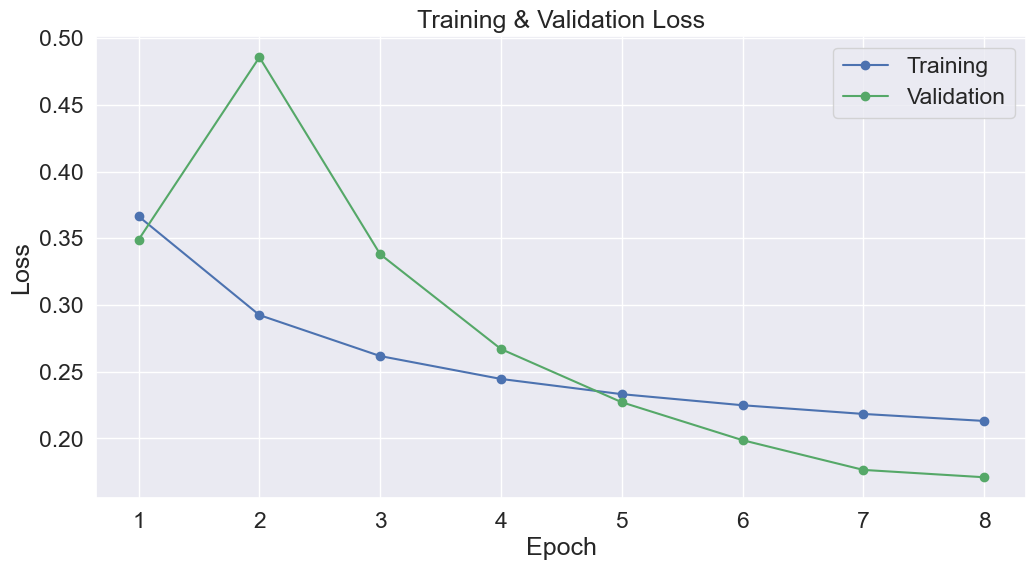

In [16]:
import seaborn as sns
import numpy as np

# plot results
def plot_results():
    # styling from seaborn.
    sns.set(style='darkgrid')
    # uncrease the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # plot the learning curve.
    plt.plot(np.arange(1,epochs+1), avg_train_losses, 'b-o', label="Training")
    plt.plot(np.arange(1,epochs+1), avg_val_losses, 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks(list(range(1, epochs+1)))

    return plt.show()


plot_results()

In [17]:
# Evaluation on the test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).squeeze().numpy()

y_pred_test_binary = (y_pred_test > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_pred_test_binary)

print(f"Testing Accuracy: {test_accuracy}")

# Classification Report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test_binary))

Testing Accuracy: 0.940677966101695
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       333
           1       0.00      0.00      0.00        21

    accuracy                           0.94       354
   macro avg       0.47      0.50      0.48       354
weighted avg       0.88      0.94      0.91       354



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.